## Optimization Implementation
Now we want to implement the optimization framework using Pymoo. We first define some information about our inductor and capacitors. These vectors include information taken from the datasheets, and are coded directly below. The loss and volume calculations are taken from Zitao Liao's journal article and thesis https://www2.eecs.berkeley.edu/Pubs/TechRpts/2022/EECS-2022-22.html. His code was invaluable in defining the loss and volume functions. He completed his work in MATLAB here https://github.com/zliao555/SSB_optimization, but used a weighted sums method for the optimization.

In [1]:
#capacitor = [voltage rating, capacitance, derated capacitance, volume]
#These are the 50V 10uF venkel caps

Capacitor1 = [50, 10e-06, 4.3e-06, 8.7,0.00001];
Capacitor2 = [50, 10e-06, 4.3e-06, 8.7, 0.00001];
#Now the inductor
#inductor = [inducatance, DCR, k coeffiecients....volume]
ind = [4.7e-05, 0.0354/2, 33.92, 313.14, 0.01515, 2.213, 1.173, 10, 13.5, 6429.28];

We can now define the loss calculations and volume calculations in the evaluate function. In the init function we define the lower bounds as 1000uF and 200uF. 

In [39]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=1,
                         xl=np.array([0.5,0.2]),
                         xu=np.array([1,1]))

    def _evaluate(self, x, out, *args, **kwargs):
        C1 = (x[0]*2000e-6);
        C2 = (x[1]*1000e-6);
        ind = [4.7e-05, 0.0354/2, 33.92, 313.14, 0.01515, 2.213, 1.173, 10, 13.5, 12858.56/2];
   
        C1_derated =4.3e-6; # In this case, this is constant! this is taken from the datasheet
        from scipy import interpolate
        idc = 10
        delta_q1max = 0.0021; #this is an estimate based on the circuit
        VC2_DC = delta_q1max/C1/np.sqrt(2*C2/(2*C2+C1))*1.01;
        C2_derated = 4.3e-6;

        #here we calculate the number of required capacitors. this is determined by the derating constants.
        N_C1 = C1/C1_derated;  #caps necessary
        N_C2 = C2/C2_derated;
        
        #now we calculate the full volume 
        Volume_C1 =  Capacitor1[3]*N_C1*1e-3; # [cm^3]
        Volume_C2 =  Capacitor2[3]*N_C2*1e-3; # [cm^3]
        Volume_L2 = 2*ind[9]*1e-3;           # [cm^3]
        
        f1 = Volume_C1 + Volume_C2 + 2*ind[9]*1e-3
        
################################################################################################   
        #HERE IS WHERE YOU IMPLEMENT SWITCHING INFORMATION
        Rgon = 15+10; # Rgate external and internal driver mosfet resistance -- THIS IS AN ESTIMATE HERE
        Rgoff = 10;
        Qgsw = 1.8e-9; #equivalent input charge to move through plateua region
        Vth = 1.5;#[V] gate-source threshold voltage
        Vdrv = 5.0; # [V] gate driver voltage 
        Igon = (Vdrv-Vth)/Rgon;
        Igoff = Vth/Rgoff;

        ton  = Qgsw/Igon;
        toff = Qgsw/Igoff;
        fs = 150e3
        rds_on = 15e-3;
        
        f_L = 60;
        T_L = 1/f_L;
        L_s = ind[0]*2;
        omega = 2*np.pi*f_L;
        N_stamp = fs/f_L; #to calculate numbers of switching instances
        
        t = np.linspace(0,T_L, int(N_stamp));
        #nowe wed define all the inductor information.
        dcr = ind[1];
        et100 = ind[2];
        k0 = ind[3];
        k1 = ind[4];
        kb = ind[5];
        kf = ind[6];
        fs_l = 2*fs;
        
        #now we find the voltages/currents going through the SSB
        N_stamp = fs/f_L; #to calculate numbers of switching instances
        t = np.linspace(0,T_L, int(N_stamp));
        vc2dc = idc/(C1*2*omega)*np.sqrt(1+C1/(2*C2))*1.01;
        vab = -idc/(C1*2*omega)*np.cos(2*omega*t);
        v2sw = np.sqrt(vc2dc**2-0.5*idc**2/(4*omega**2*C1*C2)*np.cos(4*omega*t))
        ibuf_sw = -idc*np.sin(2*omega*t);#
        iL_ripple = (v2sw-np.abs(vab))*0.5*(np.abs(vab)/v2sw)/(fs*L_s);
        
        #define the switching coss losses. These are hardcoded based on the datasheet.
        coss = 129e-12
        E_sw = v2sw*np.abs(ibuf_sw)*(ton+toff);
        p_coss = 4*coss*f_L;
        p_sw_loss = np.sum(E_sw)*f_L + p_coss;
        p_cond_avg = (idc**2/2+np.mean(iL_ripple**2)/12)*(rds_on*2);
        
        #INDUCTOR LOSSES ARE GIVING ME AN ISSUE
        #indcutor losses
        d_s = np.abs(vab/v2sw);
        fe = fs_l/(2*np.pi*d_s*(1-d_s));
        bpk =0.5*((v2sw-np.abs(vab))*d_s/fs_l*1e6)/et100*100;
        
        p_core_ins = k0*fe**(kf-1)*bpk**kb*fs_l*10**(-14);
        p_core = 2*np.average(p_core_ins); #two inductors;
        p_ac_ins = dcr*(274.5+50)/(259.5)*k1*iL_ripple**2*np.sqrt(fs_l);
        #corresponds to the numbers of switching instances
        k_f = 0.8;#scalar for fitting experimental results
        p_ac = 2*np.mean(p_ac_ins); #two inductors;;
        p_dc =  (idc**2/2 + np.mean(iL_ripple**2)/12)*2*dcr;
        ploss_ind = (p_ac+ p_dc)*k_f
        p_esr = np.mean(ibuf_sw)**2/N_C1*Capacitor1[4] + np.mean(ibuf_sw)**2/N_C2*Capacitor2[4]
    
        
      #HERE WE HAVE THE LOSS FUNCTION
        f2 = p_cond_avg + p_sw_loss + ploss_ind +p_esr;
    
        #here we define our constraints 
        Vc1RippleLimit = Capacitor1[0]*0.5
        g1 = idc/(C1*omega) - Vc1RippleLimit      
        iL_real = iL_ripple*0.5 - idc*np.sin(2*omega*t);
        I_peak = max(iL_real);

        out["F"] = [f1, f2]
        out["G"] = [g1]
        
problem = MyProblem()

from pymoo.factory import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.optimize import minimize

termination = get_termination("n_gen", 200)

from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_problem, get_visualization, get_reference_directions


Generations =200

algorithm = NSGA2(
    pop_size=60,
    n_offsprings=Generations,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob = 0.9, eta=15),
    mutation=get_mutation("real_pm", eta = 15),
    eliminate_duplicates=True)


res = minimize(problem,
               algorithm,
               termination,
               seed=2,
               save_history=True,
               verbose=True);

X = res.X
F = res.F


n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      60 |  0.00000E+00 |  0.00000E+00 |      32 |            - |            -
    2 |     260 |  0.00000E+00 |  0.00000E+00 |      60 |  0.099367122 |        ideal
    3 |     460 |  0.00000E+00 |  0.00000E+00 |      60 |  0.008421945 |        ideal
    4 |     660 |  0.00000E+00 |  0.00000E+00 |      60 |  0.005875205 |        ideal
    5 |     860 |  0.00000E+00 |  0.00000E+00 |      60 |  0.011446115 |        ideal
    6 |    1060 |  0.00000E+00 |  0.00000E+00 |      60 |  0.009474763 |        ideal
    7 |    1260 |  0.00000E+00 |  0.00000E+00 |      60 |  0.008403978 |        nadir
    8 |    1460 |  0.00000E+00 |  0.00000E+00 |      60 |  0.003025059 |        ideal
    9 |    1660 |  0.00000E+00 |  0.00000E+00 |      60 |  0.006149423 |            f
   10 |    1860 |  0.00000E+00 |  0.00000E+00 |      60 |  0.006680462 |            f
   11 |    2060 |  0.00000E+00 |  0.00000E+00 |      6

Here we run the optimization with 200 generations. I played with this value a bunch to determine how few got appropriate results. For slightly better results, the number of iterations can be increased.


Generations =200

algorithm = NSGA2(
    pop_size=60,
    n_offsprings=Generations,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob = 0.9, eta=15),
    mutation=get_mutation("real_pm", eta = 15),
    eliminate_duplicates=True)


res = minimize(problem,
               algorithm,
               termination,
               seed=2,
               save_history=True,
               verbose=True);

X = res.X
F = res.F


Now we plot our Pareto fronts!

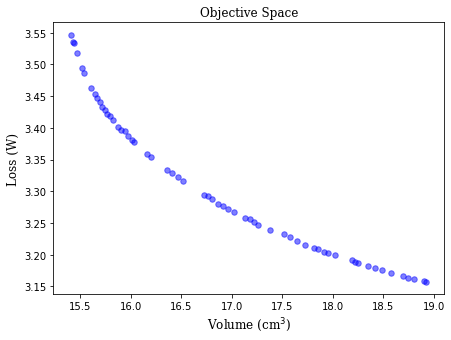

In [3]:
import matplotlib.pyplot as plt
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }
plt.figure(figsize=(7, 5))
plt.xlabel('Volume (cm$^3$)', fontdict=font)
plt.ylabel('Loss (W)', fontdict=font)
plt.scatter(F[:, 0], F[:, 1], s=30, color='blue', alpha = 0.5)
plt.title("Objective Space",fontdict=font)
plt.savefig("ga_obj.png", format="png", dpi=600)
plt.show()

### Trying new inductor
Now we change the inductor to be the IHTH1125 47uH.

In [40]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
ind = [47e-06, 0.01320, 40.02,  534.42,  0.01891, 2.213, 1.173, 8.6,12.15, 2193.20125875];
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=1,
                         xl=np.array([0.5,0.2]),
                         xu=np.array([1,1]))

    def _evaluate(self, x, out, *args, **kwargs):
        C1 = (x[0]*2000e-6);
        C2 = (x[1]*1000e-6);
        #ind = [4.7e-05, 0.0354/2, 33.92, 313.14, 0.01515, 2.213, 1.173, 10, 13.5, 12858.56/2];
        ind = [47e-06, 0.01320, 40.02,  534.42,  0.01891, 2.213, 1.173, 8.6,12.15, 2193.20125875];
   
        C1_derated =4.3e-6; # In this case, this is constant! this is taken from the datasheet
        from scipy import interpolate
        idc = 10
        delta_q1max = 0.0021; #this is an estimate based on the circuit
        VC2_DC = delta_q1max/C1/np.sqrt(2*C2/(2*C2+C1))*1.01;
        C2_derated = 4.3e-6;

        #here we calculate the number of required capacitors. this is determined by the derating constants.
        N_C1 = C1/C1_derated;  #caps necessary
        N_C2 = C2/C2_derated;
        
        #now we calculate the full volume 
        Volume_C1 =  Capacitor1[3]*N_C1*1e-3; # [cm^3]
        Volume_C2 =  Capacitor2[3]*N_C2*1e-3; # [cm^3]
        Volume_L2 = 2*ind[9]*1e-3;           # [cm^3]
        
        f1 = Volume_C1 + Volume_C2 + 2*ind[9]*1e-3
        
################################################################################################   
        #HERE IS WHERE YOU IMPLEMENT SWITCHING INFORMATION
        Rgon = 15+10; # Rgate external and internal driver mosfet resistance -- THIS IS AN ESTIMATE HERE
        Rgoff = 10;
        Qgsw = 1.8e-9; #equivalent input charge to move through plateua region
        Vth = 1.5;#[V] gate-source threshold voltage
        Vdrv = 5.0; # [V] gate driver voltage 
        Igon = (Vdrv-Vth)/Rgon;
        Igoff = Vth/Rgoff;

        ton  = Qgsw/Igon;
        toff = Qgsw/Igoff;
        fs = 150e3
        rds_on = 15e-3;
        
        f_L = 60;
        T_L = 1/f_L;
        L_s = ind[0]*2;
        omega = 2*np.pi*f_L;
        N_stamp = fs/f_L; #to calculate numbers of switching instances
        
        t = np.linspace(0,T_L, int(N_stamp));
        #nowe wed define all the inductor information.
        dcr = ind[1];
        et100 = ind[2];
        k0 = ind[3];
        k1 = ind[4];
        kb = ind[5];
        kf = ind[6];
        fs_l = 2*fs;
        
        #now we find the voltages/currents going through the SSB
        N_stamp = fs/f_L; #to calculate numbers of switching instances
        t = np.linspace(0,T_L, int(N_stamp));
        vc2dc = idc/(C1*2*omega)*np.sqrt(1+C1/(2*C2))*1.01;
        vab = -idc/(C1*2*omega)*np.cos(2*omega*t);
        v2sw = np.sqrt(vc2dc**2-0.5*idc**2/(4*omega**2*C1*C2)*np.cos(4*omega*t))
        ibuf_sw = -idc*np.sin(2*omega*t);#
        iL_ripple = (v2sw-np.abs(vab))*0.5*(np.abs(vab)/v2sw)/(fs*L_s);
        
        #define the switching coss losses. These are hardcoded based on the datasheet.
        coss = 129e-12
        E_sw = v2sw*np.abs(ibuf_sw)*(ton+toff);
        p_coss = 4*coss*f_L;
        p_sw_loss = np.sum(E_sw)*f_L + p_coss;
        p_cond_avg = (idc**2/2+np.mean(iL_ripple**2)/12)*(rds_on*2);
        
        #INDUCTOR LOSSES ARE GIVING ME AN ISSUE
        #indcutor losses
        d_s = np.abs(vab/v2sw);
        fe = fs_l/(2*np.pi*d_s*(1-d_s));
        bpk =0.5*((v2sw-np.abs(vab))*d_s/fs_l*1e6)/et100*100;
        
        p_core_ins = k0*fe**(kf-1)*bpk**kb*fs_l*10**(-14);
        p_core = 2*np.average(p_core_ins); #two inductors;
        p_ac_ins = dcr*(274.5+50)/(259.5)*k1*iL_ripple**2*np.sqrt(fs_l);
        #corresponds to the numbers of switching instances
        k_f = 0.8;#scalar for fitting experimental results
        p_ac = 2*np.mean(p_ac_ins); #two inductors;;
        p_dc =  (idc**2/2 + np.mean(iL_ripple**2)/12)*2*dcr;
        ploss_ind = (p_ac+ p_dc)*k_f
        p_esr = np.mean(ibuf_sw)**2/N_C1*Capacitor1[4] + np.mean(ibuf_sw)**2/N_C2*Capacitor2[4]
    
        
      #HERE WE HAVE THE LOSS FUNCTION
        f2 = p_cond_avg + p_sw_loss + ploss_ind +p_esr;
    
        #here we define our constraints 
        Vc1RippleLimit = Capacitor1[0]*0.5
        g1 = idc/(C1*omega) - Vc1RippleLimit      
        iL_real = iL_ripple*0.5 - idc*np.sin(2*omega*t);
        I_peak = max(iL_real);

        out["F"] = [f1, f2]
        out["G"] = [g1]
        
problem2 = MyProblem()

from pymoo.factory import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.optimize import minimize

termination = get_termination("n_gen", 200)

from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_problem, get_visualization, get_reference_directions


Generations =200

algorithm = NSGA2(
    pop_size=60,
    n_offsprings=Generations,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob = 0.9, eta=15),
    mutation=get_mutation("real_pm", eta = 15),
    eliminate_duplicates=True)


res = minimize(problem2,
               algorithm,
               termination,
               seed=2,
               save_history=True,
               verbose=True);

X2 = res.X
F2 = res.F

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      60 |  0.00000E+00 |  0.00000E+00 |      32 |            - |            -
    2 |     260 |  0.00000E+00 |  0.00000E+00 |      60 |  0.099367122 |        ideal
    3 |     460 |  0.00000E+00 |  0.00000E+00 |      60 |  0.008421945 |        ideal
    4 |     660 |  0.00000E+00 |  0.00000E+00 |      60 |  0.005875205 |        ideal
    5 |     860 |  0.00000E+00 |  0.00000E+00 |      60 |  0.011446115 |        ideal
    6 |    1060 |  0.00000E+00 |  0.00000E+00 |      60 |  0.014750312 |        ideal
    7 |    1260 |  0.00000E+00 |  0.00000E+00 |      60 |  0.006787580 |            f
    8 |    1460 |  0.00000E+00 |  0.00000E+00 |      60 |  0.005808864 |        nadir
    9 |    1660 |  0.00000E+00 |  0.00000E+00 |      60 |  0.005553847 |            f
   10 |    1860 |  0.00000E+00 |  0.00000E+00 |      60 |  0.011328179 |            f
   11 |    2060 |  0.00000E+00 |  0.00000E+00 |      6

### Changing the switches to the EPC2207
We change the switches for both cases.

In [41]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=1,
                         xl=np.array([0.5,0.2]),
                         xu=np.array([1,1]))

    def _evaluate(self, x, out, *args, **kwargs):
        C1 = (x[0]*2000e-6);
        C2 = (x[1]*1000e-6);
        ind = [4.7e-05, 0.0354/2, 33.92, 313.14, 0.01515, 2.213, 1.173, 10, 13.5, 12858.56/2];
   
        C1_derated =4.3e-6; # In this case, this is constant! this is taken from the datasheet
        from scipy import interpolate
        idc = 10
        delta_q1max = 0.0021; #this is an estimate based on the circuit
        VC2_DC = delta_q1max/C1/np.sqrt(2*C2/(2*C2+C1))*1.01;
        C2_derated = 4.3e-6;

        #here we calculate the number of required capacitors. this is determined by the derating constants.
        N_C1 = C1/C1_derated;  #caps necessary
        N_C2 = C2/C2_derated;
        
        #now we calculate the full volume 
        Volume_C1 =  Capacitor1[3]*N_C1*1e-3; # [cm^3]
        Volume_C2 =  Capacitor2[3]*N_C2*1e-3; # [cm^3]
        Volume_L2 = 2*ind[9]*1e-3;           # [cm^3]
        
        f1 = Volume_C1 + Volume_C2 + 2*ind[9]*1e-3
        
################################################################################################   
        Rgon = 15+10; # Rgate external and internal driver mosfet resistance
        Rgoff = 10;
        Qgsw = 1.8e-9; #equivalent input charge to move through plateua region
        Vth = 1.5;#[V] gate-source threshold voltage
        Vdrv = 5.0; # [V] gate driver voltage 
        Igon = (Vdrv-Vth)/Rgon;
        Igoff = Vth/Rgoff;

        ton  = Qgsw/Igon;
        toff = Qgsw/Igoff;
        fs = 150e3
        rds_on = 4.4e-3;
        
        f_L = 60;
        T_L = 1/f_L;
        L_s = ind[0]*2;
        omega = 2*np.pi*f_L;
        N_stamp = fs/f_L; #to calculate numbers of switching instances
        
        t = np.linspace(0,T_L, int(N_stamp));
        #nowe wed define all the inductor information.
        dcr = ind[1];
        et100 = ind[2];
        k0 = ind[3];
        k1 = ind[4];
        kb = ind[5];
        kf = ind[6];
        fs_l = 2*fs;
        
        #now we find the voltages/currents going through the SSB
        N_stamp = fs/f_L; #to calculate numbers of switching instances
        t = np.linspace(0,T_L, int(N_stamp));
        vc2dc = idc/(C1*2*omega)*np.sqrt(1+C1/(2*C2))*1.01;
        vab = -idc/(C1*2*omega)*np.cos(2*omega*t);
        v2sw = np.sqrt(vc2dc**2-0.5*idc**2/(4*omega**2*C1*C2)*np.cos(4*omega*t))
        ibuf_sw = -idc*np.sin(2*omega*t);#
        iL_ripple = (v2sw-np.abs(vab))*0.5*(np.abs(vab)/v2sw)/(fs*L_s);
        
        #define the switching coss losses. These are hardcoded based on the datasheet.
        coss = 129e-12
        E_sw = v2sw*np.abs(ibuf_sw)*(ton+toff);
        p_coss = 4*coss*f_L;
        p_sw_loss = np.sum(E_sw)*f_L + p_coss;
        p_cond_avg = (idc**2/2+np.mean(iL_ripple**2)/12)*(rds_on*2);
        
        #INDUCTOR LOSSES ARE GIVING ME AN ISSUE
        #indcutor losses
        d_s = np.abs(vab/v2sw);
        fe = fs_l/(2*np.pi*d_s*(1-d_s));
        bpk =0.5*((v2sw-np.abs(vab))*d_s/fs_l*1e6)/et100*100;
        
        p_core_ins = k0*fe**(kf-1)*bpk**kb*fs_l*10**(-14);
        p_core = 2*np.average(p_core_ins); #two inductors;
        p_ac_ins = dcr*(274.5+50)/(259.5)*k1*iL_ripple**2*np.sqrt(fs_l);
        #corresponds to the numbers of switching instances
        k_f = 0.8;#scalar for fitting experimental results
        p_ac = 2*np.mean(p_ac_ins); #two inductors;;
        p_dc =  (idc**2/2 + np.mean(iL_ripple**2)/12)*2*dcr;
        ploss_ind = (p_ac+ p_dc)*k_f
        p_esr = np.mean(ibuf_sw)**2/N_C1*Capacitor1[4] + np.mean(ibuf_sw)**2/N_C2*Capacitor2[4]
    
        
      #HERE WE HAVE THE LOSS FUNCTION
        f2 = p_cond_avg + p_sw_loss + ploss_ind +p_esr;
    
        #here we define our constraints 
        Vc1RippleLimit = Capacitor1[0]*0.5
        g1 = idc/(C1*omega) - Vc1RippleLimit      
        iL_real = iL_ripple*0.5 - idc*np.sin(2*omega*t);
        I_peak = max(iL_real);

        out["F"] = [f1, f2]
        out["G"] = [g1]
        
problem3 = MyProblem()

from pymoo.factory import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.optimize import minimize

termination = get_termination("n_gen", 200)

from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_problem, get_visualization, get_reference_directions


Generations =200

algorithm = NSGA2(
    pop_size=60,
    n_offsprings=Generations,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob = 0.9, eta=15),
    mutation=get_mutation("real_pm", eta = 15),
    eliminate_duplicates=True)


res = minimize(problem3,
               algorithm,
               termination,
               seed=2,
               save_history=True,
               verbose=True);

X3 = res.X
F3 = res.F


n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      60 |  0.00000E+00 |  0.00000E+00 |      32 |            - |            -
    2 |     260 |  0.00000E+00 |  0.00000E+00 |      60 |  0.099367122 |        ideal
    3 |     460 |  0.00000E+00 |  0.00000E+00 |      60 |  0.008421945 |        ideal
    4 |     660 |  0.00000E+00 |  0.00000E+00 |      60 |  0.005875205 |        ideal
    5 |     860 |  0.00000E+00 |  0.00000E+00 |      60 |  0.011446115 |        ideal
    6 |    1060 |  0.00000E+00 |  0.00000E+00 |      60 |  0.009474763 |        ideal
    7 |    1260 |  0.00000E+00 |  0.00000E+00 |      60 |  0.008403991 |        nadir
    8 |    1460 |  0.00000E+00 |  0.00000E+00 |      60 |  0.003025059 |        ideal
    9 |    1660 |  0.00000E+00 |  0.00000E+00 |      60 |  0.006149441 |            f
   10 |    1860 |  0.00000E+00 |  0.00000E+00 |      60 |  0.006680451 |            f
   11 |    2060 |  0.00000E+00 |  0.00000E+00 |      6

## Lastly we try changing both the inductor and the switch

Rgon = 15+10; # Rgate external and internal driver mosfet resistance
        Rgoff = 10;
        Qgsw = 1.8e-9; #equivalent input charge to move through plateua region
        Vth = 1.5;#[V] gate-source threshold voltage
        Vdrv = 5.0; # [V] gate driver voltage 
        Igon = (Vdrv-Vth)/Rgon;
        Igoff = Vth/Rgoff;

        ton  = Qgsw/Igon;
        toff = Qgsw/Igoff;
        fs = 150e3
        rds_on = 4.4e-3;
        
        f_L = 60;
        T_L = 1/f_L;
        L_s = ind[0]*2;
        omega = 2*np.pi*f_L;
        N_stamp = fs/f_L; #to calculate numbers of switching instances

In [42]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
ind = [47e-06, 0.01320, 40.02,  534.42,  0.01891, 2.213, 1.173, 8.6,12.15, 2193.20125875];
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=1,
                         xl=np.array([0.5,0.2]),
                         xu=np.array([1,1]))

    def _evaluate(self, x, out, *args, **kwargs):
        C1 = (x[0]*2000e-6);
        C2 = (x[1]*1000e-6);
        #ind = [4.7e-05, 0.0354/2, 33.92, 313.14, 0.01515, 2.213, 1.173, 10, 13.5, 12858.56/2];
        ind = [47e-06, 0.01320, 40.02,  534.42,  0.01891, 2.213, 1.173, 8.6,12.15, 2193.20125875];
   
        C1_derated =4.3e-6; # In this case, this is constant! this is taken from the datasheet
        from scipy import interpolate
        idc = 10
        delta_q1max = 0.0021; #this is an estimate based on the circuit
        VC2_DC = delta_q1max/C1/np.sqrt(2*C2/(2*C2+C1))*1.01;
        C2_derated = 4.3e-6;

        #here we calculate the number of required capacitors. this is determined by the derating constants.
        N_C1 = C1/C1_derated;  #caps necessary
        N_C2 = C2/C2_derated;
        
        #now we calculate the full volume 
        Volume_C1 =  Capacitor1[3]*N_C1*1e-3; # [cm^3]
        Volume_C2 =  Capacitor2[3]*N_C2*1e-3; # [cm^3]
        Volume_L2 = 2*ind[9]*1e-3;           # [cm^3]
        
        f1 = Volume_C1 + Volume_C2 + 2*ind[9]*1e-3
        
################################################################################################   
        #HERE IS WHERE YOU IMPLEMENT SWITCHING INFORMATION
        Rgon = 15+10; # Rgate external and internal driver mosfet resistance
        Rgoff = 10;
        Qgsw = 1.8e-9; #equivalent input charge to move through plateua region
        Vth = 1.5;#[V] gate-source threshold voltage
        Vdrv = 5.0; # [V] gate driver voltage 
        Igon = (Vdrv-Vth)/Rgon;
        Igoff = Vth/Rgoff;

        ton  = Qgsw/Igon;
        toff = Qgsw/Igoff;
        fs = 150e3
        rds_on = 4.4e-3;
        
        f_L = 60;
        T_L = 1/f_L;
        L_s = ind[0]*2;
        omega = 2*np.pi*f_L;
        N_stamp = fs/f_L; #to calculate numbers of switching instances
        
        t = np.linspace(0,T_L, int(N_stamp));
        #nowe wed define all the inductor information.
        dcr = ind[1];
        et100 = ind[2];
        k0 = ind[3];
        k1 = ind[4];
        kb = ind[5];
        kf = ind[6];
        fs_l = 2*fs;
        
        #now we find the voltages/currents going through the SSB
        N_stamp = fs/f_L; #to calculate numbers of switching instances
        t = np.linspace(0,T_L, int(N_stamp));
        vc2dc = idc/(C1*2*omega)*np.sqrt(1+C1/(2*C2))*1.01;
        vab = -idc/(C1*2*omega)*np.cos(2*omega*t);
        v2sw = np.sqrt(vc2dc**2-0.5*idc**2/(4*omega**2*C1*C2)*np.cos(4*omega*t))
        ibuf_sw = -idc*np.sin(2*omega*t);#
        iL_ripple = (v2sw-np.abs(vab))*0.5*(np.abs(vab)/v2sw)/(fs*L_s);
        
        #define the switching coss losses. These are hardcoded based on the datasheet.
        coss = 129e-12
        E_sw = v2sw*np.abs(ibuf_sw)*(ton+toff);
        p_coss = 4*coss*f_L;
        p_sw_loss = np.sum(E_sw)*f_L + p_coss;
        p_cond_avg = (idc**2/2+np.mean(iL_ripple**2)/12)*(rds_on*2);
        
        #INDUCTOR LOSSES ARE GIVING ME AN ISSUE
        #indcutor losses
        d_s = np.abs(vab/v2sw);
        fe = fs_l/(2*np.pi*d_s*(1-d_s));
        bpk =0.5*((v2sw-np.abs(vab))*d_s/fs_l*1e6)/et100*100;
        
        p_core_ins = k0*fe**(kf-1)*bpk**kb*fs_l*10**(-14);
        p_core = 2*np.average(p_core_ins); #two inductors;
        p_ac_ins = dcr*(274.5+50)/(259.5)*k1*iL_ripple**2*np.sqrt(fs_l);
        #corresponds to the numbers of switching instances
        k_f = 0.8;#scalar for fitting experimental results
        p_ac = 2*np.mean(p_ac_ins); #two inductors;;
        p_dc =  (idc**2/2 + np.mean(iL_ripple**2)/12)*2*dcr;
        ploss_ind = (p_ac+ p_dc)*k_f
        p_esr = np.mean(ibuf_sw)**2/N_C1*Capacitor1[4] + np.mean(ibuf_sw)**2/N_C2*Capacitor2[4]
    
        
      #HERE WE HAVE THE LOSS FUNCTION
        f2 = p_cond_avg + p_sw_loss + ploss_ind +p_esr;
    
        #here we define our constraints 
        Vc1RippleLimit = Capacitor1[0]*0.5
        g1 = idc/(C1*omega) - Vc1RippleLimit      
        iL_real = iL_ripple*0.5 - idc*np.sin(2*omega*t);
        I_peak = max(iL_real);

        out["F"] = [f1, f2]
        out["G"] = [g1]
        
problem4 = MyProblem()

from pymoo.factory import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.optimize import minimize

termination = get_termination("n_gen", 200)

from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_problem, get_visualization, get_reference_directions


Generations =200

algorithm = NSGA2(
    pop_size=60,
    n_offsprings=Generations,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob = 0.9, eta=15),
    mutation=get_mutation("real_pm", eta = 15),
    eliminate_duplicates=True)


res = minimize(problem4,
               algorithm,
               termination,
               seed=2,
               save_history=True,
               verbose=True);

X4 = res.X
F4 = res.F

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      60 |  0.00000E+00 |  0.00000E+00 |      32 |            - |            -
    2 |     260 |  0.00000E+00 |  0.00000E+00 |      60 |  0.099367122 |        ideal
    3 |     460 |  0.00000E+00 |  0.00000E+00 |      60 |  0.008421945 |        ideal
    4 |     660 |  0.00000E+00 |  0.00000E+00 |      60 |  0.005875205 |        ideal
    5 |     860 |  0.00000E+00 |  0.00000E+00 |      60 |  0.011446115 |        ideal
    6 |    1060 |  0.00000E+00 |  0.00000E+00 |      60 |  0.014750312 |        ideal
    7 |    1260 |  0.00000E+00 |  0.00000E+00 |      60 |  0.006787547 |            f
    8 |    1460 |  0.00000E+00 |  0.00000E+00 |      60 |  0.005808897 |        nadir
    9 |    1660 |  0.00000E+00 |  0.00000E+00 |      60 |  0.005553905 |            f
   10 |    1860 |  0.00000E+00 |  0.00000E+00 |      60 |  0.011527334 |            f
   11 |    2060 |  0.00000E+00 |  0.00000E+00 |      6

Now I check to see what levels of capacitance is recommended by the optimization algorithm.

In [301]:
C1 = .53052505*2000e-6
C2 = 0.20612878*1000e-6

N_C1 = C1/C1_derated;  #caps necessary
N_C2 = C2/C2_derated;

400/35/(C1*2*2*3.14*60)*np.sqrt(1+C1/(2*C2))*1.01

27.289711818501605

In [303]:
N_C2

47.93692558139534

Now we plot all of the objective functions and the design space.

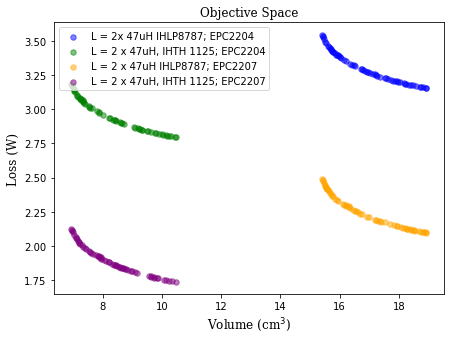

In [45]:
import matplotlib.pyplot as plt
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }



plt.figure(figsize=(7, 5))
plt.xlabel('Volume (cm$^3$)', fontdict=font)
plt.ylabel('Loss (W)', fontdict=font)
plt.scatter(F[:, 0], F[:, 1], s=30, color='blue', alpha = 0.5)
plt.scatter(F2[:, 0], F2[:, 1], s=30, color='green', alpha = 0.5)
plt.scatter(F3[:, 0], F3[:, 1], s=30, color='orange', alpha = 0.5)
plt.scatter(F4[:, 0], F4[:, 1], s=30, color='purple', alpha = 0.5)
plt.legend(['L = 2x 47uH IHLP8787; EPC2204', 'L = 2 x 47uH, IHTH 1125; EPC2204', 'L = 2 x 47uH IHLP8787; EPC2207', 'L = 2 x 47uH, IHTH 1125; EPC2207'], loc = 'upper left')
plt.title("Objective Space",fontdict=font)
plt.savefig("ga_obj2.png", format="png", dpi=600)
plt.show()

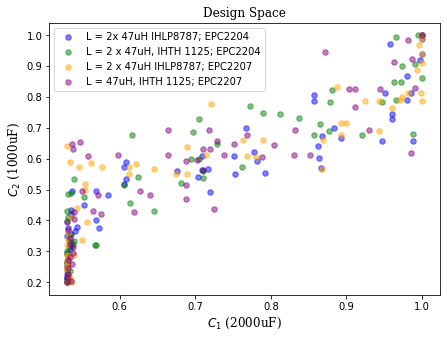

In [44]:
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30,color='blue', alpha = 0.5)
plt.scatter(X2[:, 0], X2[:, 1], s=30,color='green', alpha = 0.5)
plt.scatter(X3[:, 0], X3[:, 1], s=30,color='orange', alpha = 0.5)
plt.scatter(X4[:, 0], X4[:, 1], s=30,color='purple', alpha = 0.5)
plt.title("Design Space", fontdict=font)
#plt.title('Pareto Optimal Points for Volume and DCR', )
plt.xlabel('$C_1$ (2000uF)', fontdict=font)
plt.ylabel('$C_2$ (1000uF)', fontdict=font)
plt.legend(['L = 2x 47uH IHLP8787; EPC2204', 'L = 2 x 47uH, IHTH 1125; EPC2204', 'L = 2 x 47uH IHLP8787; EPC2207', 'L = 47uH, IHTH 1125; EPC2207'], loc = 'upper left')
#plt.legend(['L = 2x 47uH IHLP8787; EPC2204', 'L = 2 x 47uH, IHTH 1125; EPC2204', 'L = 2x 47uH IHLP8787; EPC2207', 'L = 2 x 47uH, IHTH 1125; EPC2207'], loc = 'upper left')
plt.title("Design Space",fontdict=font)
plt.savefig("ga_des2.png", format="png", dpi=600)
plt.show()

## Future exploration
Here we pursue the possibility of using weighted sums and the scipy framework. This is still under work. The results are slightly off what we would expect with back of the envelope calculations. Furthermore this takes longer to run if enough values for $\alpha$ are chosen. Check out the weighted sums method at (Z. Liao), doi: 10.1109/JESTPE.2020.2987347. For this method we first find the optimal value for loss. We then find the optimal value of volume as an initial value to normalize over. Then we repeat the same process for loss.

The total optimization minimizes $\alpha f_{volume} + (1 - \alpha) f_{loss}$ for a sweep of $\alpha$ values. 

In [40]:
import scipy
from scipy.optimize import minimize
Capacitor2= [50, 10e-6, 43e-6, 8];
Capacitor1 = [50, 10e-6, 43e-6,8];
ind = [4.7e-05, 0.0354/2, 33.92, 313.14, 0.01515, 2.213, 1.173, 10, 13.5, 12858.56/2];
idc = 10
def f(x):
    C1 = (x[0]*2000e-6);
    C2 = (x[1]*1000e-6);

    C1_derated = 4.3e-6; # In this case, this is constant!
    from scipy import interpolate

    delta_q1max = 0.0021;
    VC2_DC = delta_q1max/C1/np.sqrt(2*C2/(2*C2+C1))*1.01;
    C2_derated = 4.3e-6
    #C2_derate =interpolate.interp1d(Capacitor2[2:6], Capacitor2[6:10],fill_value="extrapolate");
    #C2_derated = C2_derate(VC2_DC)

    N_C1 = C1/C1_derated;  #caps necessary
    N_C2 = C2/C2_derated;

    Volume_C1 = 8*N_C1*1e-3; # [cm^3]
    Volume_C2 =8.*N_C2*1e-3; # [cm^3]
    Volume_L2 = 2*ind[9]*1e-3;           # [cm^3]

    return Volume_C1 + Volume_C2 + 2*ind[9]*1e-3

def con(x):
    
    f_L = 60;

    omega = 2*np.pi*f_L;
    C1 = (x[0]*1000e-6);
    C2 = (x[1]*500e-6);
    return idc/(C1*omega) - 50*0.2


    
    return np.sqrt((delta_q1max/(x[0]*500e-6)/np.sqrt(2*x[1]*1000e-6/(2*x[1]*1000e-6+(x[0]*500e-6)))*1.01)**2 + idc** 2/(2*omega**2*(x[0]*500e-6)*x[1]*1000e-6)) - Capacitor2[0]


cons = [{'type':'eq', 'fun': con}]
bnds = ((0.5, 1), (0.2, 1))
#cons = ({'type': 'ineq', 'fun': lambda x:idc/(x[0]*omega) - Vc1RippleLimit}, {'type': 'ineq', 'fun': lambda x: -x[0] - 2 * x[1] + 6},{'type': 'ineq', 'fun': lambda x: -x[0] + 2 * x[1] + 2})
f1x0 = scipy.optimize.minimize(f, [0.5, 0.5], constraints=cons,method='SLSQP', bounds=bnds)





In [8]:
f1x0

     fun: 13.184381666666667
     jac: array([ 2.66666663, 13.33333337])
 message: 'Positive directional derivative for linesearch'
    nfev: 6
     nit: 6
    njev: 2
  status: 8
 success: False
       x: array([0.9, 0.5])

In [41]:
ind = [4.7e-05, 0.0354/2, 33.92, 313.14, 0.01515, 2.213, 1.173, 10, 13.5, 12858.56/2];

def g1(x):  
    C1 = (x[0]*2000e-6);
    C2 = (x[1]*1000e-6);
        

    fs = 150e3
    Rgon = 15+10; # Rgate external and internal driver mosfet resistance
    Rgoff = 10;
    Qgsw = 1.8e-9; #equivalent input charge to move through plateua region
    Vth = 1.4;#[V] gate-source threshold voltage
    Vdrv = 5.0; # [V] gate driver voltage 
    Igon = (Vdrv-Vth)/Rgon;
    Igoff = Vth/Rgoff;

    ton  = Qgsw/Igon;
    toff = Qgsw/Igoff;

    rds_on = 15e-3;

    f_L = 60;
    T_L = 1/f_L;
    L_s = ind[0]*2;
    omega = 2*np.pi*f_L;
    N_stamp = fs/f_L; #to calculate numbers of switching instances

    t = np.linspace(0,T_L, int(N_stamp));

    dcr = ind[1];
    et100 = ind[2];
    k0 = ind[3];
    k1 = ind[4];
    kb = ind[5];
    kf = ind[6];
    fs_l = 2*fs;



    N_stamp = fs/f_L; #to calculate numbers of switching instances
    t = np.linspace(0,T_L, int(N_stamp));
    vc2dc = idc/(C1*2*omega)*np.sqrt(1+C1/(2*C2))*1.01;

    vab = -idc/(C1*2*omega)*np.cos(2*omega*t);
    v2sw = np.sqrt(vc2dc**2-0.5*idc**2/(4*omega**2*C1*C2)*np.cos(4*omega*t))
    ibuf_sw = -idc*np.sin(2*omega*t);#

    iL_ripple = (v2sw-np.abs(vab))*0.5*(np.abs(vab)/v2sw)/(fs*L_s);

    coss = 129e-12
    E_sw = v2sw*np.abs(ibuf_sw)*(ton+toff);
    p_coss = 4*coss*f_L;
    p_sw_loss = np.sum(E_sw)*f_L + p_coss;
    p_cond_avg = (idc**2/2+np.mean(iL_ripple**2)/12)*(rds_on*2);


    #indcutor losses
    d_s = np.abs(vab/v2sw);
    fe = fs_l/(2*np.pi*d_s*(1-d_s));
    bpk =0.5*((v2sw-abs(vab))*d_s/fs_l*1e6)/et100*100;

    p_core_ins = k0*fe**(kf-1)*bpk**kb*fs_l*10**(-14);
    p_core = 2*np.mean(p_core_ins); #two inductors;
    p_ac_ins = dcr*(274.5+50)/(259.5)*k1*iL_ripple**2*np.sqrt(fs_l);
   #corresponse numbers of switching instances

    k_f = 1.2;#scaler for fitting experimental results
    p_ac = 2*np.mean(p_ac_ins); #two inductors;;
    p_dc = (idc**2/2 + np.mean(iL_ripple**2)/12)*2*dcr;
    ploss_ind = (p_ac+p_core+p_dc)*k_f
    
        
        #f2=np.sum(v2sw*np.abs(ibuf_sw)*(ton+toff))*f_L + ploss_ind
    f2=p_sw_loss + ploss_ind +p_cond_avg;



    return f2
   

    

In [42]:

cons = [{'type':'eq', 'fun': con}]
bnds = ((0.5, 1), (0.2, 1))
#cons = ({'type': 'ineq', 'fun': lambda x:idc/(x[0]*omega) - Vc1RippleLimit}, {'type': 'ineq', 'fun': lambda x: -x[0] - 2 * x[1] + 6},{'type': 'ineq', 'fun': lambda x: -x[0] + 2 * x[1] + 2})
m = scipy.optimize.minimize(g1, [0.5, 0.5], constraints=cons, bounds=bnds, options={'maxiter' : 100})


In [142]:
m

     fun: 9.170400353431807
     jac: array([-0.53058028, -3.66752088])
 message: 'Optimization terminated successfully'
    nfev: 88
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([0.9       , 0.10284087])

In [43]:
#def obj(x):
Points = 100
objx = []
objfun = []
alphap = []

def obj(x, alpha):
    obj = alpha**2*f(x)/f1x0.fun + (1-alpha)**2*g1(x)/m.fun
    return obj

for j in range(1, Points+2):
    alpha = (j/Points - 1/Points);
    alphap.append(alpha)
    objp = scipy.optimize.minimize(obj, [0.5, 0.5], args=alpha, constraints=cons,method='SLSQP', bounds=bnds)
    objx.append(objp.x)
    objfun.append(objp.fun)
    

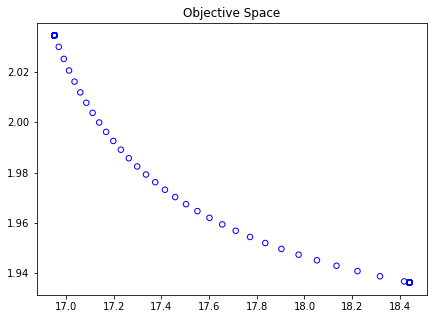

In [44]:
feval = []
geval = []
for i in range(0, len(objx)):
    feval.append(f(objx[i]))
    geval.append(g1(objx[i])/2)
    
    
plt.figure(figsize=(7, 5))
plt.scatter(feval, geval, s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

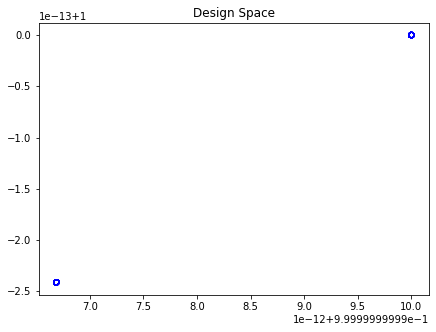

In [45]:
xs = [objx[0] for x in objx]
ys = [objx[1] for y in objx]
plt.figure(figsize=(7, 5))
plt.scatter(xs,ys, s=30, facecolors='none', edgecolors='blue')
plt.title("Design Space")
plt.show()

In [46]:
objx

[array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1.        , 0.98792397]),
 array([1.        , 0.93359963]),
 array([1.        , 0.88299169]),
 array([1.        , 0.83577787]),
 array([1.        , 0.79164753]),
 array([1.        , 0.75032783]),
 array([1.        , 0.71157455]),
 array([1.        , 0.67516924]),
 array([1.       , 0.6409295]),
 array([1.        , 0.60867345]),
 array([1.        , 0.57825073]),
 array([1.        , 0.54952112]),
 array([1.        , 0.52235652]),
 array([1.        , 0.49665843]),
 arr